### This Notebook aims at validating identified patterns in signals that can help reduce Invoice buyer fraud chargebacks, it also explores using decision tree to identify important siagnsls

In [14]:
import pandas as pd
import numpy as np

#from pydumbo import merchant_signals as MerchantSignals
from kplib.dumbo import Dumbo, DataframeInput, FeatureOptions,EvaluationOptions, FileInput

from sklearn.metrics import euclidean_distances
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

from pysnowflake.simple import Session
from pysnowflake.utils import retrieve_query
from pysnowflake.utils import write_df_to_snowflake

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import json
#import RiskarbiterService
#from pyriskarbiter.services.riskarbiter import RiskarbiterService
#from tqdm import tqdm


from sklearn.model_selection import train_test_split #
from sklearn.tree import DecisionTreeClassifier
pd.options.display.max_columns = 25
pd.options.display.max_rows = 25
pd.set_option('display.float_format', '{:.2f}'.format)

from sklearn import metrics
import blocks
from blocks.filesystem import GCSFileSystem

pd.options.display.max_rows = 4000

In [ ]:
with Session(app_name="APP_RISK") as ss:
    
    df = ss.download(
        table = "APP_RISK.APP_RISK_TEST.invoice_payments_oct_nov_2021",
        path="gs://ds-risk-prod-snowstage/nmavani/invoice_1221/data_snowflake/",
    )

In [350]:
 #pip install fsspec==2021.06.0
#!pip show fsspec


In [17]:
signallist = ['total_invoice_payment_success_count_by_email_from_invoice_buyer_email',
'total_invoice_success_count_by_merchant_from_payment_merchant',
'invoices_sent_via_email_count_by_unit_token_from_payment_merchant',
'lev_distance_between_invoice_payer_and_cardholder_name_by_id_from_payment',
'frozen_or_deactivated_not_deleted_neighbors_thru_softer_count_by_merchant_from_payment_merchant',
'millis_since_last_invoice_payment_by_unit_token_from_payment_merchant',
'auth_amount_streak_length_by_merchant_from_payment_merchant',
'bin_streak_length_by_merchant_from_payment_merchant',
#'lev_distance_between_invoice_cardholder_and_historic_name_by_id_from_payment',
'avg_amount_by_merchant_from_payment_merchant',
'auth_amount_by_id_from_payment',
'total_invoice_payment_failed_count_by_email_from_invoice_buyer_email',
'frozen_or_disabled_neighbors_thru_email_count_by_merchant_from_payment_merchant',
'negative_balance_neighbors_thru_email_count_by_merchant_from_payment_merchant',
'total_invoice_payment_success_count_by_email_from_payment_buyer_email',
'unique_invoice_payment_bins_by_email_from_invoice_buyer_email',
'unique_invoice_payment_pans_by_email_from_invoice_buyer_email',
'total_invoice_payment_failed_count_b_in_13w_by_email_from_invoice_buyer_email',
'card_country_auth_by_card_from_payment_card',
'card_country_capture_by_card_from_payment_card',
'millis_since_last_buyer_email_change_by_card_from_payment_card',
'millis_since_last_receipt_email_change_by_card_from_payment_card',
'total_success_amount_b_in_1d_by_merchant_and_card_from_payment_merchant_and_card',
'total_success_amount_b_in_1w_by_merchant_and_card_from_payment_merchant_and_card',
'total_success_amount_b_in_2d_by_merchant_and_card_from_payment_merchant_and_card',
'total_success_count_b_in_1d_by_merchant_and_card_from_payment_merchant_and_card',
'total_success_count_b_in_1w_by_merchant_and_card_from_payment_merchant_and_card',
'total_success_count_b_in_2d_by_merchant_and_card_from_payment_merchant_and_card',
'avg_success_amount_b_in_1d_by_merchant_and_card_from_payment_merchant_and_card',
'avg_success_amount_b_in_2d_by_merchant_and_card_from_payment_merchant_and_card',
'avg_success_amount_b_in_1w_by_merchant_and_card_from_payment_merchant_and_card',
'miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment',
'miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment',
'miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment',
'miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment',
'miles_from_merchant_city_to_buyer_zip_by_id_from_payment',
'miles_from_merchant_city_to_buyer_ip_by_id_from_payment',
'miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment',
'miles_from_invoice_payment_buyer_ip_to_invoice_payment_buyer_zip_by_id_from_payment',
'is_last_buyer_email_different_from_previous_by_card_from_payment_card',
'chargeback_rate_by_completed_gpv_offline_by_email_domain_from_invoice_buyer_email_domain',
'invoice_has_payer_email_by_id_from_payment',
'unique_invoice_payment_buyer_zips_by_email_from_invoice_buyer_email',
'is_card_buyer_fraud_blacklisted_by_card_from_payment_card',
'total_fraud_chargeback_amount_by_card_from_payment_card',
'total_success_count_by_card_from_payment_card',
'total_count_by_card_from_payment_card',
'miles_between_last_two_invoice_payment_buyer_ips_by_invoice_from_payment_invoice',
'miles_between_last_two_invoice_payment_buyer_zips_by_invoice_from_payment_invoice'
]


In [18]:
df_features_new = Dumbo().get_features(
        entity="REGISTER_PAYMENT",
        input_query=FileInput("gs://ds-risk-prod-snowstage/nmavani/invoice_1221/data_snowflake/", token_col="PAYMENT_TOKEN"),
        output_path="gs://ds-risk-prod-snowstage/nmavani/invoice_1221/data_dumbo",
        feature_options=FeatureOptions(
            features=signallist, 
            include_for_rules_only=True,
            include_deprecated=False,

        ),
        evaluation_options=EvaluationOptions(
            acl_reasons=["risk"]),
    )

'Waiting for job 123181 to launch'

'Job 123181 is running at https://console.cloud.google.com/dataflow/jobs/us-central1/2021-12-10_09_39_00-940238275241318866?project=risk-144219'

'Job 123181 finished successfully'

'Checking output for errors ...'

'No errors found in output'

In [20]:
df_features = blocks.assemble('gs://ds-risk-prod-snowstage/nmavani/invoice_1221/data_dumbo/results')

In [21]:
#df_data = blocks.assemble('gs://ds-risk-prod-snowstage/nmavani/invoice_0721/data_snowflake')
#df_features_new.to_csv('invoice_features.csv')

In [100]:
df_features.shape

(3325497, 80)

In [22]:
df_features.columns

Index(['UNIT_TOKEN', 'PAYMENT_TOKEN', 'PAYMENT_TRX_RECOGNIZED_AT',
       'AUTH_INTENT_CREATED_AT', 'PAY_WITH_SQUARE_ENTRY_METHOD',
       'AMOUNT_BASE_UNIT', 'CURRENCY_CODE', 'IS_CURRENTLY_DEACTIVATED',
       'IS_CURRENTLY_FROZEN', 'IS_REFUNDED', 'IS_GPV', 'DECLINE_REASONS',
       'AUTH_INTENT_AMOUNT', 'AUTH_RESULT_STATUS_CODE', 'TYPE', 'OLD_SCORE',
       'NEW_SCORE', 'AUTH_AVS_STATUS', 'AUTH_CVV_STATUS', 'UNIT_TENURE',
       'ACTIVE_TENURE', 'TAXONOMY_CATEGORY_NAME', 'REASON_CODE_TYPE',
       'CHARGEBACK_CENTS', 'LOSS_CENTS', 'BIN_PROPERTIES_COUNTRY',
       'PAN_PREFIX', 'BUSINESS_CATEGORY', 'AUTH_AMOUNT_USD', 'CHARGEBACKS_USD',
       'LOSS_USD', 'IS_CHARGEBACKED', 'FRAUD_CHARGEBACKED', 'IS_SUSPECTED',
       'IS_CASED', 'CASE_ID',
       'total_invoice_payment_success_count_by_email_from_invoice_buyer_email',
       'total_invoice_success_count_by_merchant_from_payment_merchant',
       'invoices_sent_via_email_count_by_unit_token_from_payment_merchant',
       'lev_distance_

In [23]:
print((df_features.isna().sum()*100/df_features['PAYMENT_TOKEN'].count()).sort_values())

UNIT_TOKEN                                                                                          0.00
IS_CHARGEBACKED                                                                                     0.00
FRAUD_CHARGEBACKED                                                                                  0.00
total_invoice_success_count_by_merchant_from_payment_merchant                                       0.00
invoices_sent_via_email_count_by_unit_token_from_payment_merchant                                   0.00
frozen_or_deactivated_not_deleted_neighbors_thru_softer_count_by_merchant_from_payment_merchant     0.00
bin_streak_length_by_merchant_from_payment_merchant                                                 0.00
avg_amount_by_merchant_from_payment_merchant                                                        0.00
auth_amount_by_id_from_payment                                                                      0.00
frozen_or_disabled_neighbors_thru_email_count_by_mercha

In [24]:
columns = [
    'chargeback_rate_by_completed_gpv_offline_by_email_domain_from_invoice_buyer_email_domain',
'miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment',
'miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment',
'miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment',
'total_invoice_payment_success_count_by_email_from_payment_buyer_email'
]
df_features = df_features.drop(columns,  axis=1)

In [25]:
df_features_tenured = df_features[df_features.ACTIVE_TENURE > 30 ]

In [153]:
df_features_tenured = df_features[df_features.AMOUNT_BASE_UNIT > 50000 ]

In [154]:
df_features_tenured.shape

(831230, 80)

In [27]:
df_features_tenured['PAYMENT_TRX_RECOGNIZED_AT']= df_features_tenured['PAYMENT_TRX_RECOGNIZED_AT'].dt.strftime('%Y-%m-%d %H:%M:%S').fillna(pd.NaT)
df_features_tenured['AUTH_INTENT_CREATED_AT']=df_features_tenured['AUTH_INTENT_CREATED_AT'].dt.strftime('%Y-%m-%d %H:%M:%S').fillna(pd.NaT)

In [155]:
df_features_tenured['PAYMENT_TOKEN'].count()

831230

In [156]:
df_features_tenured.groupby(['IS_SUSPECTED']).count()

,UNIT_TOKEN,PAYMENT_TOKEN,PAYMENT_TRX_RECOGNIZED_AT,AUTH_INTENT_CREATED_AT,PAY_WITH_SQUARE_ENTRY_METHOD,AMOUNT_BASE_UNIT,CURRENCY_CODE,IS_CURRENTLY_DEACTIVATED,IS_CURRENTLY_FROZEN,IS_REFUNDED,IS_GPV,DECLINE_REASONS,...,miles_from_merchant_city_to_buyer_ip_by_id_from_payment,miles_from_invoice_payment_buyer_ip_to_invoice_payment_buyer_zip_by_id_from_payment,is_last_buyer_email_different_from_previous_by_card_from_payment_card,invoice_has_payer_email_by_id_from_payment,unique_invoice_payment_buyer_zips_by_email_from_invoice_buyer_email,is_card_buyer_fraud_blacklisted_by_card_from_payment_card,total_fraud_chargeback_amount_by_card_from_payment_card,total_success_count_by_card_from_payment_card,total_count_by_card_from_payment_card,miles_between_last_two_invoice_payment_buyer_ips_by_invoice_from_payment_invoice,miles_between_last_two_invoice_payment_buyer_zips_by_invoice_from_payment_invoice,timestamp
IS_SUSPECTED,,,,,,,,,,,,,,,,,,,,,,,,,
True,6743,6743,6743,6743,6743,6743,6743,6743,6743,6743,6743,6743,...,4846,6172,6743,6743,6399,6743,6743,6743,6743,2396,2278,6743


In [157]:
df_features_tenured.describe().T

,count,mean,std,min,25%,50%,75%,max
OLD_SCORE,831230.00,0.01,0.06,0.00,0.00,0.00,0.00,1.00
NEW_SCORE,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUTH_AMOUNT_USD,831230.00,1686.67,2332.08,376.32,670.00,1000.00,1800.00,100000.00
CHARGEBACKS_USD,831230.00,2.94,136.82,0.00,0.00,0.00,0.00,49786.25
LOSS_USD,831230.00,0.78,57.40,0.00,0.00,0.00,0.00,17160.00
total_invoice_payment_success_count_by_email_from_invoice_buyer_email,808995.00,27.27,360.15,1.00,1.00,3.00,8.00,13557.00
total_invoice_success_count_by_merchant_from_payment_merchant,831230.00,640.75,1768.17,1.00,50.00,184.00,581.00,85428.00
invoices_sent_via_email_count_by_unit_token_from_payment_merchant,831230.00,696.61,1849.91,0.00,58.00,211.00,657.00,95974.00
lev_distance_between_invoice_payer_and_cardholder_name_by_id_from_payment,779894.00,5.71,6.80,0.00,0.00,3.00,10.00,155.00
frozen_or_deactivated_not_deleted_neighbors_thru_softer_count_by_merchant_from_payment_merchant,831230.00,0.85,3.51,-1.00,0.00,0.00,0.00,142.00


In [47]:
#df_features_tenured = df_features_tenured[df_features_tenured.AUTH_INTENT_CREATED_AT >= '2021-06-01' ]
#df_features_tenured = df_features_tenured[df_features_tenured.AMOUNT_BASE_UNIT> 49999]

In [158]:
print((df_features_tenured.isna().sum()*100/df_features_tenured['PAYMENT_TOKEN'].count()).sort_values())

UNIT_TOKEN                                                                                          0.00
FRAUD_CHARGEBACKED                                                                                  0.00
total_invoice_success_count_by_merchant_from_payment_merchant                                       0.00
invoices_sent_via_email_count_by_unit_token_from_payment_merchant                                   0.00
frozen_or_deactivated_not_deleted_neighbors_thru_softer_count_by_merchant_from_payment_merchant     0.00
auth_amount_streak_length_by_merchant_from_payment_merchant                                         0.00
bin_streak_length_by_merchant_from_payment_merchant                                                 0.00
avg_amount_by_merchant_from_payment_merchant                                                        0.00
auth_amount_by_id_from_payment                                                                      0.00
frozen_or_disabled_neighbors_thru_email_count_by_mercha

In [35]:
import operator

def features(signal, df, threshold, sign, columnname=None):
    operatorlookup = {
    '+': operator.add,
    '-': operator.sub,
    '*': operator.mul,
    '/': operator.truediv,
    '>': operator.gt,
    '>=': operator.ge,
    '<': operator.lt,
    '<=': operator.le
    }
    op = operatorlookup.get(sign)
    if columnname is not None:
        new_column = columnname
    else:
        new_column = sign + str(threshold) + signal
    df[new_column] = df[signal].apply(lambda x: 1 if op(x, threshold) else 0)


def features_multiple(signal1, signal2, df, threshold, sign,columnname=None):
    operatorlookup = {
    '+': operator.add,
    '-': operator.sub,
    '*': operator.mul,
    '/': operator.truediv,
    '>': operator.gt,
    '>=': operator.ge,
    '<': operator.lt,
    '<=': operator.le
    }
    op = operatorlookup.get(sign)
    
    if columnname is not None:
        new_column = columnname
    else:
        new_column = sign + str(threshold) + signal2
        
    #df[new_column] = df[signal1].apply(lambda x: 1 if op(x, threshold*df[signal2]) else 0)
    df[new_column] = op(df[signal1], threshold*df[signal2])

In [159]:
df_features_new_way = df_features_tenured.copy()

In [160]:
df_features_new_way.columns

Index(['UNIT_TOKEN', 'PAYMENT_TOKEN', 'PAYMENT_TRX_RECOGNIZED_AT',
       'AUTH_INTENT_CREATED_AT', 'PAY_WITH_SQUARE_ENTRY_METHOD',
       'AMOUNT_BASE_UNIT', 'CURRENCY_CODE', 'IS_CURRENTLY_DEACTIVATED',
       'IS_CURRENTLY_FROZEN', 'IS_REFUNDED', 'IS_GPV', 'DECLINE_REASONS',
       'AUTH_INTENT_AMOUNT', 'AUTH_RESULT_STATUS_CODE', 'TYPE', 'OLD_SCORE',
       'NEW_SCORE', 'AUTH_AVS_STATUS', 'AUTH_CVV_STATUS', 'UNIT_TENURE',
       'ACTIVE_TENURE', 'TAXONOMY_CATEGORY_NAME', 'REASON_CODE_TYPE',
       'CHARGEBACK_CENTS', 'LOSS_CENTS', 'BIN_PROPERTIES_COUNTRY',
       'PAN_PREFIX', 'BUSINESS_CATEGORY', 'AUTH_AMOUNT_USD', 'CHARGEBACKS_USD',
       'LOSS_USD', 'IS_CHARGEBACKED', 'FRAUD_CHARGEBACKED', 'IS_SUSPECTED',
       'IS_CASED', 'CASE_ID',
       'total_invoice_payment_success_count_by_email_from_invoice_buyer_email',
       'total_invoice_success_count_by_merchant_from_payment_merchant',
       'invoices_sent_via_email_count_by_unit_token_from_payment_merchant',
       'lev_distance_

In [172]:
features('CHARGEBACKS_USD', df_features_new_way, 0, '>')
features('OLD_SCORE', df_features_new_way, 0.1, '>=', 'model_score')
df_features_new_way['suspected'] = df_features_new_way['IS_SUSPECTED'] == True
df_features_new_way['cased'] = df_features_new_way['IS_CASED'] == True
df_features_new_way['AVS_mismatch'] = df_features_new_way.AUTH_AVS_STATUS == 'AVS_REJECTED'

features_multiple('auth_amount_by_id_from_payment','avg_amount_by_merchant_from_payment_merchant', df_features_new_way, 5, '>', 'auth_5x_avg')
features_multiple('auth_amount_by_id_from_payment','avg_amount_by_merchant_from_payment_merchant', df_features_new_way, 10, '>', 'auth_10x_avg')

features('is_last_buyer_email_different_from_previous_by_card_from_payment_card', df_features_new_way, 1, '>=', '>is_last_buyer_email_different_from_previous_by_card_from_payment_card')
features('invoice_has_payer_email_by_id_from_payment', df_features_new_way, 0, '<=', '>invoice_has_payer_email_by_id_from_payment')
features('miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment', df_features_new_way, 300, '>', '>miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment')
features('miles_from_merchant_city_to_buyer_ip_by_id_from_payment', df_features_new_way, 300, '>', '>miles_from_merchant_city_to_buyer_ip_by_id_from_payment')
features('total_success_count_by_card_from_payment_card', df_features_new_way, 1, '<=', '>1total_success_count_by_card_from_payment_card')
features('total_invoice_payment_success_count_by_email_from_invoice_buyer_email', df_features_new_way, 1, '<=', '>1total_invoice_payment_success_count_by_email_from_invoice_buyer_email')

df_features_new_way['>miles_ip'] = (df_features_new_way['>miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] |  df_features_new_way['>miles_from_merchant_city_to_buyer_ip_by_id_from_payment']) 
df_features_new_way['>new_email_or_pan'] = (df_features_new_way['>1total_success_count_by_card_from_payment_card'] |  df_features_new_way['>1total_invoice_payment_success_count_by_email_from_invoice_buyer_email']) 
df_features_new_way['>miles_ip_and_new_email_or_pan'] = (df_features_new_way['>miles_ip'] |  df_features_new_way['>new_email_or_pan']) 
df_features_new_way['>miles_ip_and_new_email_or_pan_and_model_score'] = df_features_new_way['>miles_ip_and_new_email_or_pan'] & df_features_new_way['model_score']


df_features_new_way['>invoice_has_payer_email_by_id_from_payment_and_large_payment'] = (df_features_new_way['>invoice_has_payer_email_by_id_from_payment'] &  df_features_new_way['auth_10x_avg']) 
df_features_new_way['>invoice_has_payer_email_by_id_from_payment_and_large_payment_and_model_score'] = (df_features_new_way['>invoice_has_payer_email_by_id_from_payment'] &  df_features_new_way['auth_10x_avg'])  & df_features_new_way['model_score']
# features_multiple('total_success_amount_b_in_1d_by_merchant_and_card_from_payment_merchant_and_card','avg_amount_by_merchant_from_payment_merchant', df_features_new_way, 5, '>', '1d_card_amount_5x_avg')
# features_multiple('total_success_amount_b_in_1d_by_merchant_and_card_from_payment_merchant_and_card','avg_amount_by_merchant_from_payment_merchant', df_features_new_way, 10, '>', '1d_card_amount_10x_avg')
# features('total_success_count_b_in_1d_by_merchant_and_card_from_payment_merchant_and_card', df_features_new_way, 1, '>', '>1_payment_from_card_in_1d')
# features('total_success_amount_b_in_1d_by_merchant_and_card_from_payment_merchant_and_card', df_features_new_way, 99999, '>', '>1000_payment_from_card_in_1d')




In [173]:
df_features_new_way.columns

Index(['UNIT_TOKEN', 'PAYMENT_TOKEN', 'PAYMENT_TRX_RECOGNIZED_AT',
       'AUTH_INTENT_CREATED_AT', 'PAY_WITH_SQUARE_ENTRY_METHOD',
       'AMOUNT_BASE_UNIT', 'CURRENCY_CODE', 'IS_CURRENTLY_DEACTIVATED',
       'IS_CURRENTLY_FROZEN', 'IS_REFUNDED', 'IS_GPV', 'DECLINE_REASONS',
       'AUTH_INTENT_AMOUNT', 'AUTH_RESULT_STATUS_CODE', 'TYPE', 'OLD_SCORE',
       'NEW_SCORE', 'AUTH_AVS_STATUS', 'AUTH_CVV_STATUS', 'UNIT_TENURE',
       'ACTIVE_TENURE', 'TAXONOMY_CATEGORY_NAME', 'REASON_CODE_TYPE',
       'CHARGEBACK_CENTS', 'LOSS_CENTS', 'BIN_PROPERTIES_COUNTRY',
       'PAN_PREFIX', 'BUSINESS_CATEGORY', 'AUTH_AMOUNT_USD', 'CHARGEBACKS_USD',
       'LOSS_USD', 'IS_CHARGEBACKED', 'FRAUD_CHARGEBACKED', 'IS_SUSPECTED',
       'IS_CASED', 'CASE_ID',
       'total_invoice_payment_success_count_by_email_from_invoice_buyer_email',
       'total_invoice_success_count_by_merchant_from_payment_merchant',
       'invoices_sent_via_email_count_by_unit_token_from_payment_merchant',
       'lev_distance_

In [174]:
df_group =  df_features_new_way.drop(df_features_new_way.iloc[:, 3:79],axis=1).groupby(['>0CHARGEBACKS_USD', 'suspected']).sum().T

In [175]:
df_group

>0CHARGEBACKS_USD                                        0           1      
suspected                                            False True  False True 
model_score                                           5150  3888    72   330
cased                                                    0  6057     0   307
AVS_mismatch                                         31778   252    28     7
auth_5x_avg                                         181488  2216   170   118
auth_10x_avg                                         96625  1290    79    67
>is_last_buyer_email_different_from_previous_by...   23899   107    11     5
>invoice_has_payer_email_by_id_from_payment          21731   306    64    36
>miles_from_buyer_ip_to_buyer_card_zip_by_id_fr...  109052  2768   126   204
>miles_from_merchant_city_to_buyer_ip_by_id_fro...  162343  2240   205   140
>1total_success_count_by_card_from_payment_card     135987  1862   199    79
>1total_invoice_payment_success_count_by_email_...  255331  2713   357   181
>miles_ip                                           211418  3784   260   241
>new_email_or_pan                                   319230  3564   431   207
>miles_ip_and_new_email_or_pan                      443921  5203   538   321
>miles_ip_and_new_email_or_pan_and_model_score        4478  3455    60   297
>invoice_has_payer_email_by_id_from_payment_and...    1705    52     4     5
>invoice_has_payer_email_by_id_from_payment_and...      71    45     1     5

In [176]:
columns= ('recall%', 'precision%', 'total_payments', 'incremental_payments_suspected', 'incremental_chargebacks_suspected')
df_pr_recall = pd.DataFrame(index=df_group.T.columns, columns=columns)

 ##recall  (chargebacks detected of total chargebacks)
df_pr_recall['recall%']=(df_group[1][True]+df_group[1][False])*100/sum(df_features_new_way['>0CHARGEBACKS_USD']==1)

 ##precision (charegacks detected of all payments flagged)
df_pr_recall['precision%'] = (df_group[1][True]+df_group[1][False])/(df_group[1][True]+df_group[1][False]+df_group[0][True]+df_group[0][False])*100


df_pr_recall['total_payments'] = df_group[1][True]+df_group[1][False]+df_group[0][True]+df_group[0][False]
df_pr_recall['incremental_payments_suspected'] = (df_group[0][False]+df_group[1][False])
df_pr_recall['incremental_chargebacks_suspected'] = df_group[1][False]


df_pr_recall.sort_values(by=['precision%'])


# columns= ('recall%', 'precision%')
# df_pr_recall_rm = pd.DataFrame(index=df_group.T.columns, columns=columns)

# ##recall  (chargebacks detected of total chargebacks)
# df_pr_recall_rm['recall%']=df_group[1]*100/sum(df_features_new_way['IS_CHARGRBACKED']==1)

# ##precision (charegacks detected of all payments flagged)
# df_pr_recall_rm['precision%'] = df_group[1]/(df_group[1]+df_group[0])*100

# df_pr_recall_rm.sort_values(by=['precision%'])

,recall%,precision%,total_payments,incremental_payments_suspected,incremental_chargebacks_suspected
>is_last_buyer_email_different_from_previous_by_card_from_payment_card,1.36,0.07,24022,23910,11
AVS_mismatch,2.97,0.11,32065,31806,28
auth_10x_avg,12.40,0.15,98061,96704,79
auth_5x_avg,24.47,0.16,183992,181658,170
>miles_ip_and_new_email_or_pan,72.98,0.19,449983,444459,538
>new_email_or_pan,54.21,0.20,323432,319661,431
>1total_success_count_by_card_from_payment_card,23.62,0.20,138127,136186,199
>1total_invoice_payment_success_count_by_email_from_invoice_buyer_email,45.71,0.21,258582,255688,357
>miles_from_merchant_city_to_buyer_ip_by_id_from_payment,29.31,0.21,164928,162548,205
>miles_ip,42.57,0.23,215703,211678,260


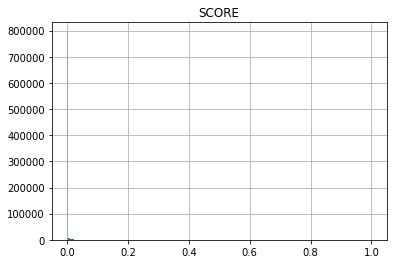

In [195]:
df_features_new_way.hist(column='SCORE', bins = 235);

In [169]:
sum(df_features_new_way['>0CHARGEBACKS_USD'])

2628

In [1]:
columns_remain = df_features_new_way.drop(df_features_new_way.iloc[:, 0:66],axis=1).columns.tolist()
remove_cols = [ 'UNIT_TOKEN', '>0CHARGEBACK_CENTS', 'suspected', 'bf_tagged_by_bfp', 'cased']
columns_remain = [ele for ele in columns_remain if ele not in remove_cols]
columns= ( 'rule', 'incremental_sellers_cased')
df_inc_seller = pd.DataFrame( columns=columns)
df_intm = df_inc_seller
# for column in columns_remain:
#     df_intm['rule']= column
#     df_features_new_way[column] = df_features_new_way[column].fillna(0).astype(int)
#     shortlist_col = [column, 'UNIT_TOKEN', '>0CHARGEBACK_CENTS', 'suspected']
#     groupby_col = [column, '>0CHARGEBACK_CENTS', 'suspected']
#     df_groupby = (df_features_new_way[shortlist_col].groupby(groupby_col).agg({ "UNIT_TOKEN": pd.Series.nunique})).T
#     df_intm['incremental_sellers_cased'] = df_groupby[1][0][False] + df_groupby[1][1][False] 
#     df_inc_seller = df_inc_seller.append(df_intm)
#     print(column)

#columns_remain = ['failed_by_email_in_13w']
for column in columns_remain:
    df_intm['rule']= column
    df_features_new_way[column] = df_features_new_way[column].fillna(0).astype(int)
    shortlist_col = [column, 'UNIT_TOKEN', '>0CHARGEBACK_CENTS', 'suspected']
    groupby_col = [column, '>0CHARGEBACK_CENTS', 'suspected']
    df_groupby = (df_features_new_way[shortlist_col].groupby(groupby_col).agg({ "UNIT_TOKEN": pd.Series.nunique})).T
    df_intm['incremental_sellers_cased'] = df_groupby[1][0][False] + df_groupby[1][1][False] 
    df_inc_seller = df_inc_seller.append(df_intm)
    print(column)

In [258]:
df_inc_seller

,rule,incremental_sellers_cased
UNIT_TOKEN,NaN,17667
UNIT_TOKEN,NaN,17667
UNIT_TOKEN,connected_to_bad_user_by_email_or_soft,17646
UNIT_TOKEN,>3x_avg,127895
UNIT_TOKEN,pans_bins_gt_1_by_email,73980
UNIT_TOKEN,gt_2_failed_by_email,19448
UNIT_TOKEN,fail_rate_by_email,15168
UNIT_TOKEN,failed_by_email_in_13w,30158
UNIT_TOKEN,auth_streak_by_bfp,4311
UNIT_TOKEN,bin_streak_by_bfp,6240


In [161]:
df_features_new_way.head().T

,0,1,2,3,4
UNIT_TOKEN,L195MTDATH71S,LZQN8AJG6GHWC,LC495E1TGXT7D,7JGZ044QP1SAB,VAB15HG5SAF2W
PAYMENT_TOKEN,JmzL7LIiBUoSnrg7oNVBir7juaB,bZw9s01F1QyfJ6KKTZZOOJOYuaB,T3RDp735KcCboQecLgdIf7nMvaB,DpWrXfCCxTYhRgzGNfrtj3ChvaB,DZOfHeI4lG0Pr5HMlQsVc455taB
PAYMENT_TRX_RECOGNIZED_AT,2021-06-25 15:28:14,2021-06-18 11:41:56,2021-06-04 20:44:31,2021-07-05 19:27:18,2021-06-20 18:06:13
AUTH_INTENT_CREATED_AT,2021-06-25 15:28:10,2021-06-18 11:41:51,2021-06-04 20:44:27,2021-07-05 19:27:14,2021-06-20 18:06:08
PAY_WITH_SQUARE_ENTRY_METHOD,INVOICE_WEB_FORM,INVOICE_WEB_FORM,INVOICE_WEB_FORM,INVOICE_WEB_FORM,INVOICE_WEB_FORM
AMOUNT_BASE_UNIT,16500,1066,4972,2400,257500
CURRENCY_CODE,USD,USD,CAD,USD,USD
IS_CURRENTLY_DEACTIVATED,0,0,0,0,0
IS_CURRENTLY_FROZEN,0,0,0,0,0
IS_REFUNDED,0,0,0,0,0


### Decision Tree


In [260]:
df_model = df_features_tenured.copy()


In [261]:
df_model['merchant_invoice_declined_1h'] = (df_model['invoice_declined_count_in_1h_by_merchant_from_payment_merchant'].gt(0) | \
                                                      df_model['invoice_on_file_declined_count_in_1h_by_merchant_from_payment_merchant'].gt(0))


df_model['connected_to_bad_user_by_email_or_soft'] = (df_model['frozen_or_disabled_neighbors_thru_email_count_by_merchant_from_payment_merchant'].gt(0) | \
                                                                df_model['negative_balance_neighbors_thru_email_count_by_merchant_from_payment_merchant'].gt(0)| \
                                                                df_model['frozen_or_deactivated_not_deleted_neighbors_thru_softer_count_by_merchant_from_payment_merchant'].gt(0))


features('avg_amount_by_merchant_from_payment_merchant', df_model, 3, '>', '>3x_avg')

#EMAIL BASED SIGNALS


df_model['pans_bins_gt_1_by_email'] = df_model['unique_invoice_payment_pans_by_email_from_invoice_buyer_email'].gt(1) | \
                                                      df_model['unique_invoice_payment_bins_by_email_from_invoice_buyer_email'].gt(1)

features('total_invoice_payment_failed_count_by_email_from_invoice_buyer_email', df_model, 2, '>', 'gt_2_failed_by_email')

df_model['fail_rate_by_email'] = df_model['total_invoice_payment_failed_count_by_email_from_invoice_buyer_email']/df_model['total_invoice_payment_success_count_by_email_from_invoice_buyer_email'] >= 0.7

features('total_invoice_payment_failed_count_b_in_13w_by_email_from_invoice_buyer_email', df_model, 0, '>', 'failed_by_email_in_13w')

#BROWSER FINGER PRINT BASED SIGNALS

features('auth_amount_streak_length_by_browser_fingerprint_from_payment_browser_fingerprint', df_model, 2, '>', 'auth_streak_by_bfp')

features('bin_streak_length_by_browser_fingerprint_from_payment_browser_fingerprint', df_model, 2, '>', 'bin_streak_by_bfp')

features('total_declined_count_by_browser_fingerprint_from_payment_browser_fingerprint', df_model, 2, '>', 'gt_2_declined_by_bfp')

features('total_count_in_10min_by_browser_fingerprint_from_payment_browser_fingerprint', df_model, 2, '>', 'gt_1_payment_by_bfp')

features('unique_pans_declined_by_browser_fingerprint_from_payment_browser_fingerprint', df_model, 2, '>', 'gt_1_pan_declined_by_bfp')



df_model['bf_tagged_by_bfp'] = df_model['bad_buyer_tagged_payments_count_by_merchant_and_browser_fingerprint_from_payment_merchant_and_browser_fingerprint'].gt(0) | \
                                                      df_model['buyer_fraud_tagged_payments_count_by_merchant_and_browser_fingerprint_from_payment_merchant_and_browser_fingerprint'].gt(0)

df_model['declince_rate_by_bfp_amt'] = df_model.total_declined_amount_by_browser_fingerprint_from_payment_browser_fingerprint/df_model.total_amount_by_browser_fingerprint_from_payment_browser_fingerprint >= 0.7

features('CHARGEBACK_CENTS', df_model, 0, '>')
features('SCORE', df_model, 0.01, '>=', 'model_score')
df_model['suspected'] = df_model['IS_SUSPECTED'] == True
df_model['cased'] = df_model['IS_CASED'] == True
df_model['AVS_mismatch'] = df_model.AUTH_AVS_STATUS == 'AVS_REJECTED'

In [262]:
df_model.columns

Index(['UNIT_TOKEN', 'PAYMENT_TOKEN', 'PAYMENT_TRX_RECOGNIZED_AT',
       'AUTH_INTENT_CREATED_AT', 'PAY_WITH_SQUARE_ENTRY_METHOD',
       'AMOUNT_BASE_UNIT', 'CURRENCY_CODE', 'IS_CURRENTLY_DEACTIVATED',
       'IS_CURRENTLY_FROZEN', 'IS_REFUNDED', 'IS_GPV', 'DECLINE_REASONS',
       'AUTH_INTENT_AMOUNT', 'AUTH_RESULT_STATUS_CODE', 'TYPE', 'SCORE',
       'AUTH_AVS_STATUS', 'AUTH_CVV_STATUS', 'TENURE',
       'TAXONOMY_CATEGORY_NAME', 'CHARGEBACK_CENTS', 'LOSS_CENTS',
       'AUTH_AMOUNT_USD', 'CHARGEBACKS_USD', 'LOSS_USD', 'IS_CHARGRBACKED',
       'CONCERNS_SUSPECTED', 'IS_SUSPECTED', 'IS_CASED', 'CASE_ID',
       'total_invoice_payment_success_count_by_email_from_invoice_buyer_email',
       'total_invoice_success_count_by_merchant_from_payment_merchant',
       'invoices_sent_via_email_count_by_unit_token_from_payment_merchant',
       'lev_distance_between_invoice_payer_and_cardholder_name_by_id_from_payment',
       'frozen_or_deactivated_not_deleted_neighbors_thru_softer_count_b

In [ ]:
#df_model = df_model.dropna()
#df_model.shape

In [286]:
X = df_model.drop(df_model.iloc[:, 0:66], axis= 1).drop(['>0CHARGEBACK_CENTS', 'suspected', 'cased'], axis=1) # Features
y = df_model['>0CHARGEBACK_CENTS'].apply(lambda x: 0 if x == 0 else 1) # Target variable

feature_cols = X.columns

#from sklearn import preprocessing
#number = preprocessing.LabelEncoder()
#X['business_type'] = number.fit_transform(X.business_type)
#X['amount_bucket'] = number.fit_transform(X.amount_bucket)
#X['entry_method'] = number.fit_transform(X.entry_method)
#X['risk_manager_enrolled'] = number.fit_transform(X.risk_manager_enrolled)
#y['is_chargebacked'] = number.fit_transform(y.is_chargebacked)
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [290]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=5, class_weight = {0:, 1:})

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [291]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.998956872955471


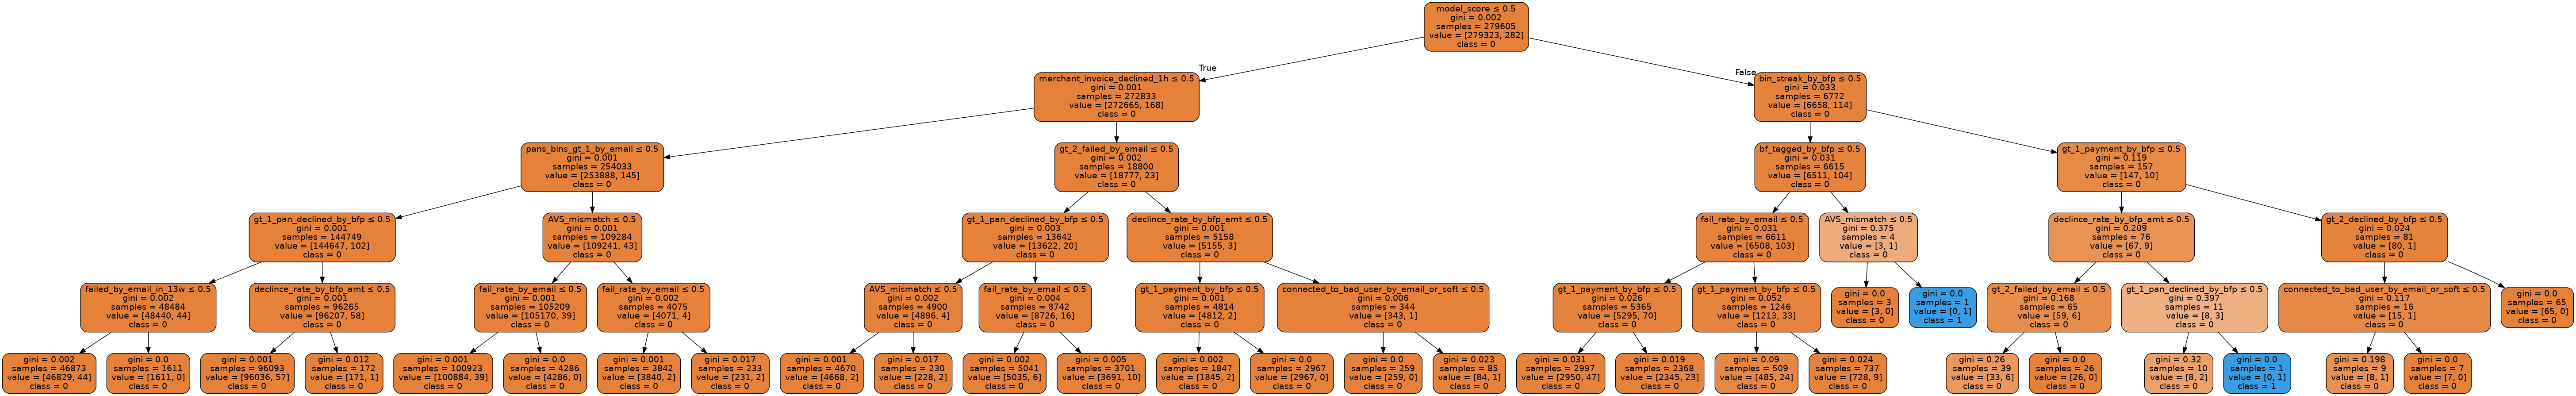

In [292]:
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from six import StringIO

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decisionTree.png')
Image(graph.create_png())

In [271]:
X.head()

,timestamp,merchant_invoice_declined_1h,connected_to_bad_user_by_email_or_soft,>3x_avg,pans_bins_gt_1_by_email,gt_2_failed_by_email,fail_rate_by_email,failed_by_email_in_13w,auth_streak_by_bfp,bin_streak_by_bfp,gt_2_declined_by_bfp,gt_1_payment_by_bfp,gt_1_pan_declined_by_bfp,bf_tagged_by_bfp,declince_rate_by_bfp_amt,model_score,suspected,cased,AVS_mismatch
4,1624212368641,False,False,1,False,0,False,0,0,0,0,0,0,False,False,0,False,False,False
29,1624658839362,False,True,1,False,1,False,0,0,0,1,1,1,False,False,0,False,False,False
42,1623252281135,False,False,1,False,0,False,0,0,0,0,0,0,False,False,0,False,False,False
63,1625154563360,False,False,1,True,0,False,0,0,0,0,0,0,False,False,0,False,False,False
64,1622650690321,False,False,1,True,0,False,0,0,0,1,1,1,False,False,0,False,False,False


In [195]:

df_features_new_way['merchant_invoice_declined_1h'] = (df_features_new_way['invoice_declined_count_in_1h_by_merchant_from_payment_merchant'].gt(0) | \
                                                      df_features_new_way['invoice_on_file_declined_count_in_1h_by_merchant_from_payment_merchant'].gt(0))


# df_features_new_way['connected_to_bad_user_by_email_or_soft'] = (df_features_new_way['frozen_or_disabled_neighbors_thru_email_count_by_merchant_from_payment_merchant'].gt(0) | \
#                                                                 df_features_new_way['negative_balance_neighbors_thru_email_count_by_merchant_from_payment_merchant'].gt(0)| \
#                                                                 df_features_new_way['frozen_or_deactivated_not_deleted_neighbors_thru_softer_count_by_merchant_from_payment_merchant'].gt(0))
# features('avg_amount_by_merchant_from_payment_merchant', df_features_new_way, 3, '>', '>3x_avg')

features('bin_streak_length_by_merchant_from_payment_merchant', df_features_new_way, 2, '>', '>2_bin_streak')
features('auth_amount_streak_length_by_merchant_from_payment_merchant', df_features_new_way, 2, '>', '>2_auth_streak')
features('bin_streak_length_by_merchant_from_payment_merchant', df_features_new_way, 3, '>', '>3_bin_streak')
features('auth_amount_streak_length_by_merchant_from_payment_merchant', df_features_new_way, 3, '>', '>3_auth_streak')


#EMAIL BASED SIGNALS


# df_features_new_way['pans_bins_gt_1_by_email'] = df_features_new_way['unique_invoice_payment_pans_by_email_from_invoice_buyer_email'].gt(1) | \
#                                                       df_features_new_way['unique_invoice_payment_bins_by_email_from_invoice_buyer_email'].gt(1)
features('total_invoice_payment_failed_count_by_email_from_invoice_buyer_email', df_features_new_way, 2, '>', 'gt_2_failed_by_email')
# df_features_new_way['fail_rate_by_email'] = df_features_new_way['total_invoice_payment_failed_count_by_email_from_invoice_buyer_email']/df_features_new_way['total_invoice_payment_success_count_by_email_from_invoice_buyer_email'] >= 0.7
# features('total_invoice_payment_failed_count_b_in_13w_by_email_from_invoice_buyer_email', df_features_new_way, 0, '>', 'failed_by_email_in_13w')

#BROWSER FINGER PRINT BASED SIGNALS

features('auth_amount_streak_length_by_browser_fingerprint_from_payment_browser_fingerprint', df_features_new_way, 2, '>', 'auth_streak_by_bfp')

features('bin_streak_length_by_browser_fingerprint_from_payment_browser_fingerprint', df_features_new_way, 2, '>', 'bin_streak_by_bfp')

features('total_declined_count_by_browser_fingerprint_from_payment_browser_fingerprint', df_features_new_way, 2, '>', 'gt_2_declined_by_bfp')

features('total_count_in_10min_by_browser_fingerprint_from_payment_browser_fingerprint', df_features_new_way, 2, '>', 'gt_1_payment_by_bfp')

features('unique_pans_declined_by_browser_fingerprint_from_payment_browser_fingerprint', df_features_new_way, 2, '>', 'gt_1_pan_declined_by_bfp')



# df_features_new_way['bf_tagged_by_bfp'] = df_features_new_way['bad_buyer_tagged_payments_count_by_merchant_and_browser_fingerprint_from_payment_merchant_and_browser_fingerprint'].gt(0) | \
#                                                       df_features_new_way['buyer_fraud_tagged_payments_count_by_merchant_and_browser_fingerprint_from_payment_merchant_and_browser_fingerprint'].gt(0)

# df_features_new_way['declince_rate_by_bfp_amt'] = df_features_new_way.total_declined_amount_by_browser_fingerprint_from_payment_browser_fingerprint/df_features_new_way.total_amount_by_browser_fingerprint_from_payment_browser_fingerprint >= 0.7

features('CHARGEBACKS_USD', df_features_new_way, 0, '>')
#features('SCORE', df_features_new_way, 0.01, '>=', 'model_score')
features('probability_bf_global_invoice_over100', df_features_new_way, 0.9, '>=', 'model_score')

df_features_new_way['suspected'] = df_features_new_way['IS_SUSPECTED'] == True
df_features_new_way['cased'] = df_features_new_way['IS_CASED'] == True
df_features_new_way['AVS_mismatch'] = df_features_new_way.AUTH_AVS_STATUS == 'AVS_REJECTED'


#COMBINED SIGNALS

#df_features_new_way['high_decline_rate_and_high_declines_by_bfp']=df_features_new_way['declince_rate_by_bfp_amt'] & df_features_new_way['gt_2_declined_by_bfp'] Just 5 incremental chargeback
#df_features_new_way['bin_or_auth_streak_and_declines_by_bfp'] = df_features_new_way.gt_2_declined_by_bfp & (df_features_new_way.bin_streak_by_bfp | df_features_new_way.auth_streak_by_bfp) Just 10 incremental chargebacks
#df_features_new_way['declined_by_bfp_and_email'] = df_features_new_way.gt_2_declined_by_bfp &  df_features_new_way.gt_2_failed_by_email just 19 incremental chargeback
#df_features_new_way['decline_and_model_score'] = df_features_new_way['declined_by_bfp_and_email_and_merchant'] & df_features_new_way['model_score']  Just 7 incremental chargebacks


df_features_new_way['declined_by_bfp_and_email_and_merchant'] = (df_features_new_way.gt_2_declined_by_bfp |  df_features_new_way.gt_2_failed_by_email) & df_features_new_way.merchant_invoice_declined_1h
df_features_new_way['bin_streak_or_auth_streak'] = df_features_new_way['>2_bin_streak'] | df_features_new_way['>2_auth_streak']
df_features_new_way['bin_or_auth_streak_by_bfp'] = (df_features_new_way.bin_streak_by_bfp | df_features_new_way.auth_streak_by_bfp)
df_features_new_way['bin_or_auth_and_decline'] = df_features_new_way['declined_by_bfp_and_email_and_merchant'] & df_features_new_way['bin_or_auth_streak_by_bfp']
df_features_new_way['bin_or_auth_by_instrument_and_decline'] = df_features_new_way['declined_by_bfp_and_email_and_merchant'] & df_features_new_way['bin_streak_or_auth_streak']
df_features_new_way['bin_or_auth_by_bfp_bin_streak_auth_streak_by_payment_and_decline'] = df_features_new_way['declined_by_bfp_and_email_and_merchant'] & df_features_new_way['bin_or_auth_streak_by_bfp'] & df_features_new_way['bin_streak_or_auth_streak']

###adding all with model score

df_features_new_way['declined_by_bfp_and_email_and_merchant_and_model_score'] = df_features_new_way['declined_by_bfp_and_email_and_merchant'] & df_features_new_way['model_score']
df_features_new_way['bin_streak_or_auth_streak_and_model_score'] = df_features_new_way['bin_streak_or_auth_streak']  & df_features_new_way['model_score']
df_features_new_way['bin_or_auth_streak_by_bfp_and_model_score'] = df_features_new_way['bin_or_auth_streak_by_bfp']  & df_features_new_way['model_score']
df_features_new_way['bin_or_auth_and_decline_and_model_score'] = df_features_new_way['bin_or_auth_and_decline'] & df_features_new_way['model_score']
df_features_new_way['bin_or_auth_by_bfp_bin_streak_auth_streak_by_payment_and_decline_and_model_score'] = df_features_new_way['bin_or_auth_by_bfp_bin_streak_auth_streak_by_payment_and_decline'] & df_features_new_way['model_score']
df_features_new_way['bin_or_auth_by_instrument_and_decline_and_model_score'] = df_features_new_way['bin_or_auth_by_instrument_and_decline'] & df_features_new_way['model_score']
#df_features_new_way['connected_to_bad_user_model_score'] = df_features_new_way['connected_to_bad_user_by_email_or_soft'] & df_features_new_way['model_score']
#df_features_new_way['connected_to_bad_and_decline_activity'] = df_features_new_way['connected_to_bad_user_by_email_or_soft'] & (df_features_new_way['merchant_invoice_declined_1h'] | df_features_new_way['gt_2_failed_by_email'] | df_features_new_way['gt_2_declined_by_bfp'])




In [88]:
features('total_count_in_10min_by_browser_fingerprint_from_payment_browser_fingerprint', df_features_new_way, 1, '>')
features('total_declined_count_by_browser_fingerprint_from_payment_browser_fingerprint', df_features_new_way, 0, '>', 'bfp_declined')
features('invoice_on_file_declined_count_in_1h_by_merchant_from_payment_merchant', df_features_new_way, 0, '>')
features('millis_since_last_decline_auth_by_card_from_payment_card', df_features_new_way, 7200000, '<', 'card_decline_in_2h')
features('millis_since_last_decline_auth_by_card_from_payment_card', df_features_new_way, 14400000, '<', 'card_decline_in_4h')
features('invoice_declined_count_in_1h_by_merchant_from_payment_merchant', df_features_new_way, 0, '>')


features('lev_distance_between_invoice_payer_and_cardholder_name_by_id_from_payment', df_features_new_way, 1, '>', 'cardholder_payer_name_mismatch')
features('total_chargeback_v6_count_by_merchant_and_browser_fingerprint_from_payment_merchant_and_browser_fingerprint', df_features_new_way, 0, '>', 'chargeback_on_bfp')
features('frozen_or_deactivated_not_deleted_neighbors_thru_softer_count_by_merchant_from_payment_merchant', df_features_new_way, 0 , '>', 'connected_to_frozen_da_soft')
features('invoices_sent_via_email_count_by_unit_token_from_payment_merchant', df_features_new_way, 0, '>', 'email_repeat_on_merchant')
features('total_invoice_success_count_by_merchant_from_payment_merchant', df_features_new_way, 1, '<=', 'first_invoice_by_count')
features('millis_since_last_invoice_payment_by_unit_token_from_payment_merchant', df_features_new_way, 0, '>', 'first_invoice_by_millis')

features_multiple('auth_amount_by_id_from_payment','avg_amount_by_merchant_from_payment_merchant', df_features_new_way, 3, '>')
features_multiple('auth_amount_by_id_from_payment','avg_amount_by_merchant_from_payment_merchant', df_features_new_way, 2, '>')


features('miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment', df_features_new_way, 0, '>')
features('miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment', df_features_new_way, 199, '>')

features('miles_from_merchant_city_to_buyer_zip_by_id_from_payment', df_features_new_way, 99, '>')
features('miles_from_merchant_city_to_buyer_ip_by_id_from_payment', df_features_new_way, 149, '>')

features('SCORE', df_features_new_way, 0.9, '>=')
features('SCORE', df_features_new_way, 0.1, '>=')
features('SCORE', df_features_new_way, 0, '>')
features('SCORE', df_features_new_way, 0.8, '>=')
features('TENURE', df_features_new_way, 30, '>')
#features('IS_CASED', df_features_new_way, 1, '>=')

features('CHARGEBACK_CENTS', df_features_new_way, 0, '>')

df_features_new_way['suspected'] = df_features_new_way['IS_SUSPECTED'] == True
df_features_new_way['cased'] = df_features_new_way['IS_CASED'] == True
df_features_new_way['AVS_mismatch'] = df_features_new_way.AUTH_AVS_STATUS == 'AVS_REJECTED'

df_features_new_way['miles'] = \
(df_features_new_way['>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment'] | \
df_features_new_way['>199miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] | \
df_features_new_way['>149miles_from_merchant_city_to_buyer_ip_by_id_from_payment']  )

df_features_new_way['merchant_declined_in_1h'] = \
(df_features_new_way['>0invoice_declined_count_in_1h_by_merchant_from_payment_merchant'] | \
 df_features_new_way['>0invoice_on_file_declined_count_in_1h_by_merchant_from_payment_merchant'] ) 



df_features_new_way['declines'] = \
(df_features_new_way['merchant_declined_in_1h'] | \
df_features_new_way['>0total_declined_count_by_browser_fingerprint_from_payment_browser_fingerprint'] | \
df_features_new_way['<7200000millis_since_last_decline_auth_by_card_from_payment_card'])

df_features_new_way['first_invoice_or_repeat_email_or_bad_connection_or_name_mismatch_and_0.9model_score'] =\
df_features_new_way['>=0.9SCORE'] & \
(df_features_new_way['first_invoice_by_millis'] | \
df_features_new_way['email_repeat_on_merchant'] | \
df_features_new_way['connected_to_frozen_da_soft'] | \
df_features_new_way['cardholder_payer_name_mismatch'] )




df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch'] =\
(
df_features_new_way['email_repeat_on_merchant'] & \
df_features_new_way['connected_to_frozen_da_soft'] & \
df_features_new_way['cardholder_payer_name_mismatch'] )



df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined'] =\
(
df_features_new_way['email_repeat_on_merchant'] & \
df_features_new_way['connected_to_frozen_da_soft'] & \
df_features_new_way['cardholder_payer_name_mismatch'] & \
df_features_new_way['bfp_declined']
)


df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_miles'] =\
(
df_features_new_way['email_repeat_on_merchant'] & \
df_features_new_way['connected_to_frozen_da_soft'] & \
df_features_new_way['cardholder_payer_name_mismatch'] & \
df_features_new_way['bfp_declined'] & \
df_features_new_way['miles'] 
)


df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_miles_and >2xavg'] =\
(
df_features_new_way['email_repeat_on_merchant'] & \
df_features_new_way['connected_to_frozen_da_soft'] & \
df_features_new_way['cardholder_payer_name_mismatch'] & \
df_features_new_way['bfp_declined'] & \
df_features_new_way['miles'] & \
df_features_new_way['>2avg_amount_by_merchant_from_payment_merchant']
)


df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_miles_and >2xavg_and_declines'] =\
(
df_features_new_way['email_repeat_on_merchant'] & \
df_features_new_way['connected_to_frozen_da_soft'] & \
df_features_new_way['cardholder_payer_name_mismatch'] & \
df_features_new_way['bfp_declined'] & \
df_features_new_way['miles'] & \
df_features_new_way['>2avg_amount_by_merchant_from_payment_merchant'] & \
df_features_new_way['declines']
)


df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_0.1_model_score'] =\
(
df_features_new_way['email_repeat_on_merchant'] & \
df_features_new_way['connected_to_frozen_da_soft'] & \
df_features_new_way['cardholder_payer_name_mismatch'] & \
df_features_new_way['>=0.1SCORE'])



df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_0.1_model_score'] =\
(
df_features_new_way['email_repeat_on_merchant'] & \
df_features_new_way['connected_to_frozen_da_soft'] & \
df_features_new_way['cardholder_payer_name_mismatch'] & \
df_features_new_way['bfp_declined'] & \
df_features_new_way['>=0.1SCORE']
)


df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_miles_and_0.1_model_score'] =\
(
df_features_new_way['email_repeat_on_merchant'] & \
df_features_new_way['connected_to_frozen_da_soft'] & \
df_features_new_way['cardholder_payer_name_mismatch'] & \
df_features_new_way['bfp_declined'] & \
df_features_new_way['miles'] & \
df_features_new_way['>=0.1SCORE']
)



# df_features_new_way['bin_and_auth_streak'] = (df_features_new_way.bin_streak_by_bfp & df_features_new_way.auth_streak_by_bfp)
#df_features_new_way['connectedf_to_bad_user_and_failed_by_email']= df_features_new_way.connected_to_bad_user_by_email_or_soft & df_features_new_way.failed_by_email_in_13w Just 8 inremental
# df_features_new_way['declined_by_bfp_and_email_and_more_than_1_pan_bins']= df_features_new_way.declined_by_bfp & df_features_new_way.failed_by_email_in_13w & df_features_new_way.pans_bins_gt_1_by_email
# df_features_new_way['declined_by_bfp_and_email_and_merchant_more_than_1_pan_bins']= df_features_new_way.declined_by_bfp & df_features_new_way.failed_by_email_in_13w & df_features_new_way.pans_bins_gt_1_by_email & df_features_new_way.merchant_invoice_declined_1h
# df_features_new_way['declined_by_bfp_and_email_and_merchant_more_than_1_pan_bins_gt_1_pan_declined']= df_features_new_way['declined_by_bfp_and_email_and_merchant_more_than_1_pan_bins'] & df_features_new_way['gt_1_pan_declined_by_bfp']
# df_features_new_way['gt_1_payment_by_bfp_and_declines_by_email_bfp'] = df_features_new_way.gt_1_payment_by_bfp & df_features_new_way.declined_by_bfp & df_features_new_way.failed_by_email_in_13w
# df_features_new_way['fail_rates_high_by_bfp_email' ] = df_features_new_way.fail_rate_by_email & df_features_new_way.declince_rate_by_bfp_amt



# df_features_new_way['declines_and_model_score'] =df_features_new_way['declined_by_bfp_and_email_and_merchant'] & df_features_new_way['model_score']
# df_features_new_way['declines_more_1_pan_or_bin_by_email_and_model_score'] = df_features_new_way['declined_by_bfp_and_email_and_merchant_more_than_1_pan_bins'] & df_features_new_way['model_score']
# df_features_new_way['declines_more_1_pan_or_bin_by_email_and_model_score_and_>3xavg'] = df_features_new_way['declines_more_1_pan_or_bin_by_email_and_model_score'] & df_features_new_way['>3x_avg']

# 
# #features('invoice_declined_count_in_1h_by_merchant_from_payment_merchant', df_features_new_way, 0, '>', 'merchant_declined_1h')
# #features('invoice_on_file_declined_count_in_1h_by_merchant_from_payment_merchant', df_features_new_way, 0, '>', 'merchant_declined_1h')


# features('total_count_in_10min_by_browser_fingerprint_from_payment_browser_fingerprint', df_features_new_way, 1, '>')
# features('total_declined_count_by_browser_fingerprint_from_payment_browser_fingerprint', df_features_new_way, 0, '>', 'bfp_declined')
# features('invoice_on_file_declined_count_in_1h_by_merchant_from_payment_merchant', df_features_new_way, 0, '>')
# features('millis_since_last_decline_auth_by_card_from_payment_card', df_features_new_way, 7200000, '<', 'card_decline_in_2h')
# features('millis_since_last_decline_auth_by_card_from_payment_card', df_features_new_way, 14400000, '<', 'card_decline_in_4h')



# features('lev_distance_between_invoice_payer_and_cardholder_name_by_id_from_payment', df_features_new_way, 1, '>', 'cardholder_payer_name_mismatch')
# features('total_chargeback_v6_count_by_merchant_and_browser_fingerprint_from_payment_merchant_and_browser_fingerprint', df_features_new_way, 0, '>', 'chargeback_on_bfp')
# features('frozen_or_deactivated_not_deleted_neighbors_thru_softer_count_by_merchant_from_payment_merchant', df_features_new_way, 0 , '>', 'connected_to_frozen_da_soft')
# features('invoices_sent_via_email_count_by_unit_token_from_payment_merchant', df_features_new_way, 0, '>', 'email_repeat_on_merchant')
# features('total_invoice_success_count_by_merchant_from_payment_merchant', df_features_new_way, 1, '<=', 'first_invoice_by_count')
# features('millis_since_last_invoice_payment_by_unit_token_from_payment_merchant', df_features_new_way, 0, '>', 'first_invoice_by_millis')

# features_multiple('auth_amount_by_id_from_payment','avg_amount_by_merchant_from_payment_merchant', df_features_new_way, 3, '>')
# features_multiple('auth_amount_by_id_from_payment','avg_amount_by_merchant_from_payment_merchant', df_features_new_way, 2, '>')


# features('miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment', df_features_new_way, 0, '>')
# features('miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment', df_features_new_way, 199, '>')

# features('miles_from_merchant_city_to_buyer_zip_by_id_from_payment', df_features_new_way, 99, '>')
# features('miles_from_merchant_city_to_buyer_ip_by_id_from_payment', df_features_new_way, 149, '>')





# df_features_new_way['miles'] = \
# (df_features_new_way['>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment'] | \
# df_features_new_way['>199miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] | \
# df_features_new_way['>149miles_from_merchant_city_to_buyer_ip_by_id_from_payment']  )

# df_features_new_way['merchant_declined_in_1h'] = \
# (df_features_new_way['>0invoice_declined_count_in_1h_by_merchant_from_payment_merchant'] | \
#  df_features_new_way['>0invoice_on_file_declined_count_in_1h_by_merchant_from_payment_merchant'] ) 



# df_features_new_way['declines'] = \
# (df_features_new_way['merchant_declined_in_1h'] | \
# df_features_new_way['>0total_declined_count_by_browser_fingerprint_from_payment_browser_fingerprint'] | \
# df_features_new_way['<7200000millis_since_last_decline_auth_by_card_from_payment_card'])

# df_features_new_way['first_invoice_or_repeat_email_or_bad_connection_or_name_mismatch_and_0.9model_score'] =\
# df_features_new_way['>=0.9SCORE'] & \
# (df_features_new_way['first_invoice_by_millis'] | \
# df_features_new_way['email_repeat_on_merchant'] | \
# df_features_new_way['connected_to_frozen_da_soft'] | \
# df_features_new_way['cardholder_payer_name_mismatch'] )




# df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch'] =\
# (
# df_features_new_way['email_repeat_on_merchant'] & \
# df_features_new_way['connected_to_frozen_da_soft'] & \
# df_features_new_way['cardholder_payer_name_mismatch'] )



# df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined'] =\
# (
# df_features_new_way['email_repeat_on_merchant'] & \
# df_features_new_way['connected_to_frozen_da_soft'] & \
# df_features_new_way['cardholder_payer_name_mismatch'] & \
# df_features_new_way['bfp_declined']
# )


# df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_miles'] =\
# (
# df_features_new_way['email_repeat_on_merchant'] & \
# df_features_new_way['connected_to_frozen_da_soft'] & \
# df_features_new_way['cardholder_payer_name_mismatch'] & \
# df_features_new_way['bfp_declined'] & \
# df_features_new_way['miles'] 
# )


# df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_miles_and >2xavg'] =\
# (
# df_features_new_way['email_repeat_on_merchant'] & \
# df_features_new_way['connected_to_frozen_da_soft'] & \
# df_features_new_way['cardholder_payer_name_mismatch'] & \
# df_features_new_way['bfp_declined'] & \
# df_features_new_way['miles'] & \
# df_features_new_way['>2avg_amount_by_merchant_from_payment_merchant']
# )


# df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_miles_and >2xavg_and_declines'] =\
# (
# df_features_new_way['email_repeat_on_merchant'] & \
# df_features_new_way['connected_to_frozen_da_soft'] & \
# df_features_new_way['cardholder_payer_name_mismatch'] & \
# df_features_new_way['bfp_declined'] & \
# df_features_new_way['miles'] & \
# df_features_new_way['>2avg_amount_by_merchant_from_payment_merchant'] & \
# df_features_new_way['declines']
# )


# df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_0.1_model_score'] =\
# (
# df_features_new_way['email_repeat_on_merchant'] & \
# df_features_new_way['connected_to_frozen_da_soft'] & \
# df_features_new_way['cardholder_payer_name_mismatch'] & \
# df_features_new_way['>=0.1SCORE'])



# df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_0.1_model_score'] =\
# (
# df_features_new_way['email_repeat_on_merchant'] & \
# df_features_new_way['connected_to_frozen_da_soft'] & \
# df_features_new_way['cardholder_payer_name_mismatch'] & \
# df_features_new_way['bfp_declined'] & \
# df_features_new_way['>=0.1SCORE']
# )


# df_features_new_way['repeat_email_and_bad_connection_and_name_mismatch_and_bfp_declined_and_miles_and_0.1_model_score'] =\
# (
# df_features_new_way['email_repeat_on_merchant'] & \
# df_features_new_way['connected_to_frozen_da_soft'] & \
# df_features_new_way['cardholder_payer_name_mismatch'] & \
# df_features_new_way['bfp_declined'] & \
# df_features_new_way['miles'] & \
# df_features_new_way['>=0.1SCORE']
# )

KeyError: '>0total_declined_count_by_browser_fingerprint_from_payment_browser_fingerprint'